In [10]:
# installing kaggle library

In [11]:
!pip install kaggle


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# configuring the path of kaggle .json file

In [13]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
# API to fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# extracting the compressed dataset

from zipfile import ZipFile
dataset = 'sentiment140.zip'

with ZipFile(dataset,'r') as z:
  z.extractall()
  print('The dataset is extracted')

The dataset is extracted


Importing the dependencies

In [3]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from joblib import Parallel, delayed
import nltk

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# printing the stopwords in english
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Data Processing

In [5]:
# loading the data from csv file to pandas dataframe
#twitter_data = pd.read_csv('training.1600000.processed.noemoticon.csv', nrows=10000, encoding = 'ISO-8859-1')

In [6]:
# checking the number of rows and columns
#twitter_data.shape


In [7]:
# printing the 1st 5 rows of the dataframe
#twitter_data.head()

In [5]:
# naming the columns and reading the dataset again

column_names = ['target','id','date','flag','user','text']
twitter_data = pd.read_csv('training.1600000.processed.noemoticon.csv', names=column_names, encoding = 'ISO-8859-1')

In [5]:
# checking the number of rows and columns
twitter_data.shape

(1600000, 6)

In [6]:
# printing the 1st 5 rows of the dataframe
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
# counting the number of missing values in the dataset
twitter_data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [8]:
# checking the distribution of target column
twitter_data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

Convert the target from "4" to "1"

In [9]:
#twitter_data.replace({'target':{4:1}}, inplace=True)

In [10]:
# checking the distribution of target column
twitter_data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [6]:
twitter_data['target'] = twitter_data['target'].map({0: 0, 4: 1})

# Separate the rows based on their target values
data_0 = twitter_data[twitter_data['target'] == 0]
data_1 = twitter_data[twitter_data['target'] == 1]

0--> Negative Tweet
1--> Positive Tweet

In [12]:
data_0

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
799995,0,2329205009,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,dandykim,Sick Spending my day laying in bed listening ...
799996,0,2329205038,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,bigenya,Gmail is down?
799997,0,2329205473,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,LeeLHoke,rest in peace Farrah! So sad
799998,0,2329205574,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,davidlmulder,@Eric_Urbane Sounds like a rival is flagging y...


In [13]:
data_1

,target,id,date,flag,user,text
800000,1,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,1,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,1,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,1,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


**Stemming**

Stemming is the process of reducing a word to its Root Word

In [14]:
# port_stem = PorterStemmer()

In [15]:
# def stemming(content):
#   stemmed_content = re.sub('[^a-zA-Z0-9\s]',' ',content)
#   stemmed_content = stemmed_content.lower()
#   stemmed_content = stemmed_content.split()
#   stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
#   stemmed_content = ' '.join(stemmed_content)
# 
#   return stemmed_content

In [7]:
# Initialize the Snowball stemmer and stopwords list outside the function
snowball_stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

In [8]:
def stemming(content, stopWords):
    # Remove non-alphanumeric characters and convert to lowercase
    stemmed_content = re.sub('[^a-zA-Z0-9\s]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    # Stem the words and remove stopwords
    stemmed_content = [snowball_stemmer.stem(word) for word in stemmed_content if word not in stopWords]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [9]:
#Parallel Stemming
twitter_data['stemmed_content'] = Parallel(n_jobs=-1)(delayed(stemming)(text, stop_words) for text in twitter_data['text'])

In [ ]:
# twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming) # 50 minutes to complete this execution

In [19]:
twitter_data.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com 2y1zl awww bummer ...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save 50 res...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [10]:
print(twitter_data['stemmed_content'])

0          switchfoot http twitpic com 2y1zl awww bummer ...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save 50 res...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi 38th birthday boo alll time tupac amaru ...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [21]:
print(twitter_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [11]:
# separating the data and label
X = twitter_data['stemmed_content'].values
Y = twitter_data['target'].values

In [23]:
print(X)

['switchfoot http twitpic com 2y1zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save 50 rest go bound' ...
 'readi mojo makeov ask detail'
 'happi 38th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph4h']


In [24]:
print(Y)

[0 0 0 ... 1 1 1]


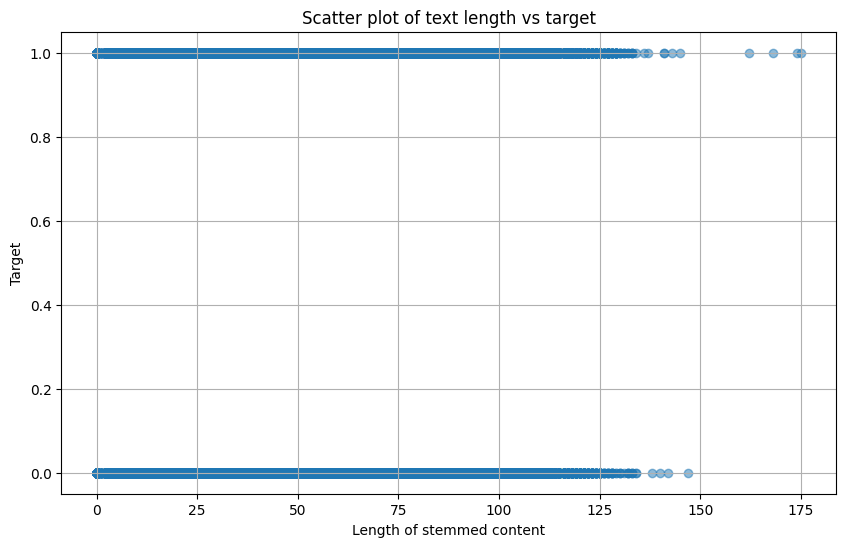

In [12]:
text_lengths = [len(text) for text in X]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(text_lengths, Y, alpha=0.5)
plt.title('Scatter plot of text length vs target')
plt.xlabel('Length of stemmed content')
plt.ylabel('Target')
plt.grid(True)
plt.show()

Splitting the data into training data and test data

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=42)

In [14]:
print(X.shape, X_train.shape, X_test.shape)

(1600000,) (1440000,) (160000,)


In [15]:
print(X_train)

['brandempir time cud meet b ur welcom 2 come c last fri finish till 5 30 get time'
 'start feel wors cannot wait doctor appt ugh could use cheer'
 'happi mother day mama' ... 'new group twi tune'
 'bought 2 chocol bar quot 1 5 6 win free bar quot label win either'
 'solobassstev look love still want get reverb use wav give littl air']


In [16]:
print(X_test)

['wow twitter serious peopl need prayer sing begin feel lot like myspac everi tweet throw lol'
 'rick bayless beauti bet go cook someth yummi' 'ihuntmidget thank' ...
 'tarynvonfabu sorri miss fab twitter ident crisi cuando venga prepar ti di cardio hit beach'
 'went mate wed last night great day even parti cut short due grant start work 5am today'
 'wearestereo anyth guy lt 3 spam street team littl www myspac com stereossteam summergirl summergirl']


In [17]:
# converting the textual data to numerical data

vector = TfidfVectorizer()

X_train = vector.fit_transform(X_train)
X_test = vector.transform(X_test)

In [31]:
print(X_train)

  (0, 96834)	0.5380436556694671
  (0, 504559)	0.31356962817002026
  (0, 137927)	0.3585730843931348
  (0, 334244)	0.2285214017241614
  (0, 524219)	0.21835012806917958
  (0, 537603)	0.23602981122357997
  (0, 129585)	0.17585816281867128
  (0, 298072)	0.17848225106992938
  (0, 197363)	0.28761483344375083
  (0, 190317)	0.21879716849359257
  (0, 504368)	0.235192991254394
  (0, 11907)	0.24551441257416565
  (0, 205421)	0.13794928097108267
  (1, 474184)	0.24514708498266613
  (1, 187836)	0.2062676471457405
  (1, 545696)	0.3397264732116774
  (1, 108491)	0.33965209994448714
  (1, 533969)	0.22689542327482679
  (1, 159879)	0.3487853513278498
  (1, 64297)	0.4227352734409292
  (1, 520566)	0.28066490433291535
  (1, 133239)	0.24471800987508402
  (1, 524788)	0.2535480015449791
  (1, 117702)	0.33435728059054864
  (2, 220448)	0.41569958690934344
  :	:
  (1439996, 94022)	0.8589813616440045
  (1439997, 368089)	0.28367395905521253
  (1439997, 215025)	0.4704244424039779
  (1439997, 515237)	0.4842847244609756
 

In [32]:
print(X_test)

  (0, 82195)	0.3096488746392471
  (0, 181509)	0.2662587752297925
  (0, 187836)	0.1827881720029129
  (0, 305724)	0.1631321274811512
  (0, 311558)	0.1776690991145812
  (0, 313546)	0.23402548833594924
  (0, 360440)	0.29694834528840025
  (0, 366062)	0.18939246666238235
  (0, 395556)	0.21913576887665184
  (0, 406451)	0.3350215053206977
  (0, 448991)	0.2679915317068127
  (0, 459240)	0.2879728729954512
  (0, 502898)	0.32014680550529034
  (0, 516190)	0.21651834209416987
  (0, 517892)	0.1966978894874982
  (0, 545894)	0.24443037432861509
  (1, 79002)	0.5840467726419294
  (1, 80636)	0.271941028990752
  (1, 84873)	0.32412696369753785
  (1, 131589)	0.31485895438769407
  (1, 209555)	0.15497673062408324
  (1, 426918)	0.4284232666968343
  (1, 466888)	0.2523251640428851
  (1, 559819)	0.33092404486938576
  (2, 239251)	0.9462236506530338
  :	:
  (159998, 181372)	0.20346768148462566
  (159998, 213026)	0.36750799771027853
  (159998, 213450)	0.18911650640786298
  (159998, 298072)	0.18597561606189797
  (1599

Training the machine learning model:

1. Logistic Regression

In [98]:
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train, Y_train) 

LogisticRegression(max_iter=1000)

2. Naive Bayes

In [65]:
model2 = MultinomialNB(alpha=1.0)
model2.fit(X_train, Y_train)

ValueError: could not convert string to float: 'brandempir time cud meet b ur welcom 2 come c last fri finish till 5 30 get time'

In [ ]:
# model3 = SVC()
# model3.fit(X_train, Y_train)

3. Support Vector Machine (SVM)

In [ ]:
model3 = SentimentIntensityAnalyzer()
pred=model3.polarity_scores(X_train)

4. Random Forest Classifier

In [ ]:
# model4 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='auto')
# model4.fit(X_train, Y_train)

Model Evaluation

In [99]:
# accuracy score on the training data
X_train_pred = model1.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_pred)

In [100]:
print('Accuracy score on the training data: ', training_data_accuracy)

Accuracy score on the training data:  0.8013388888888889


In [101]:
# accuracy score on the test data
X_test_pred = model1.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_pred)

In [102]:
print('Accuracy score on the test data: ', test_data_accuracy)

Accuracy score on the test data:  0.77675


Model Accuracy (LR)= 77.66%, (NB)= 75.09%, (SVM)= 76.96%

Saving the trained model

In [ ]:
import pickle

In [ ]:
saved_model = 'saved_model3.sav'
pickle.dump(model3, open(saved_model,'wb'))

Using the saved model for future predictions

In [ ]:
# loading the saved model
loaded_model = pickle.load(open('saved_model3.sav', 'rb'))

In [ ]:
X_new = X_test[200]
print(Y_test[200])

prediction = loaded_model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print("Negative tweet")

else:
  print("Positive tweet")